In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import math
from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy
from scipy.special import erf
import numpy
from numpy import exp
from numpy.lib.scimath import log, sqrt
from matplotlib.pyplot import figure
%config InlineBackend.figure_format='retina'

## Exercise 04: Molecular dynamics

The central topic of the exercise is molecular dynamics. Loosely speaking molecular dynamics (MD) integrates the microscopic equations of motion that govern the time evolution of a system of "molecules". After letting the system reach equilibrium a measure of the thermodynamic quantities (such as pressure) can be performed relating the microscopic coordinates to the macroscopic quantities through the fundamental virial theorem.
The problem approached is the simulation of an Argon system with Lennard-Jones potential

### Verlet algorithm

The integration of the trajectories of the particles makes use of the Verlet algorithm. It is derived from two Taylor expansion suitably chosen:
- $\vec{r}(t+\delta t) = \vec{r}(t) + \delta t \vec{v}(t) + \frac{1}{2} \delta t^2 \vec{a}(t) + \frac{1}{3!} \delta t^3 \dot{\vec{a}}(t) + \mathcal{O}(\delta t^4)$
- $\vec{r}(t-\delta t) = \vec{r}(t) - \delta t \vec{v}(t) + \frac{1}{2} \delta t^2 \vec{a}(t) - \frac{1}{3!} \delta t^3 \dot{\vec{a}}(t) + \mathcal{O}(\delta t^4)$
which in turn yield:

$$
\vec{r}(t+\delta t) = 2\vec{r}(t)-\vec{r}(t-\delta t) + \delta t^2\vec{a}(t)
$$
The firrst reason why this algorithm is widely used is for the symmetric role that the negative and positive increments ($-\delta t \, \delta t$), making the resulting computation time reversible. Another reason is that it has been shown to be an exceptionally energy conserving algorithm, making it suitable in order to compute thermodynamic quantities. The goal is not to have precise trajectories of each particle, but to have a good simulation of a statistical system (energy conservation is the key law to keep in mind).

### PBC: Periodic Boundary Conditions
In order to have a computationally efficient code a reduction of the system size is needed. The goal of the simulation is to predict the bulk properties of a material knowing the temperature and all the parametrs entering the microscopic Hamiltonian. This is achieved via the use of periodic boundary conditions: a much smaller system is studied as if submerged in an infinite copy of itself. This yields the periodic conditions: a particle does not hit the walls of the box but simply reappears on the opposite wall with the same velocity value.

<img src="PBC.png" alt="drawing" width="300"/>

#### Potential energy and periodicity

A problem that could arise is the fact that a certain periodicity is being imposed on the system; this problem especially comes into play if the potential is long ranged. In the case of Lennard Jones or any other short ranged potential this is not an issue as only few particles sense the periodic images in adjacent boxes. The question of interaction between particles also poses a much more immediate problem that is the calculation of the potential energy itself. In the exercise the minimum image convention is followed. Interaction between a tagged particle in the simulation box and *every other particle in the system* must be taken into consideration. Clearly this yields an infinite sum (being there infinite repeated boxes); this problem is avoided at first approximation considering interaction of each "box-particle" only with particles lying inside a region the same size of the box itself (this includes "virtual particles", see image). A second stronger approximation is the one of making the cutoff shape a sphere embedded in the translated box.

<img src="MIC.png" alt="drawing" width="300"/>

### Lennard Jones potential and natural units

Natural units are a smart way to make different problems the same. Convenient units of length $\sigma$ energy $\epsilon$ and mass $m$ are chosen to make the treatment adimensional. In these units the Lennard Jones potential becomes:
$$
V_{LE}^*(r^*) = 4\left[\left(\frac{1}{r^*}\right)^{12}-\left(\frac{1}{r^*}\right)^6\right]
$$
Clearly also temperature, pressure, time etc. inherit the same adimensionality.


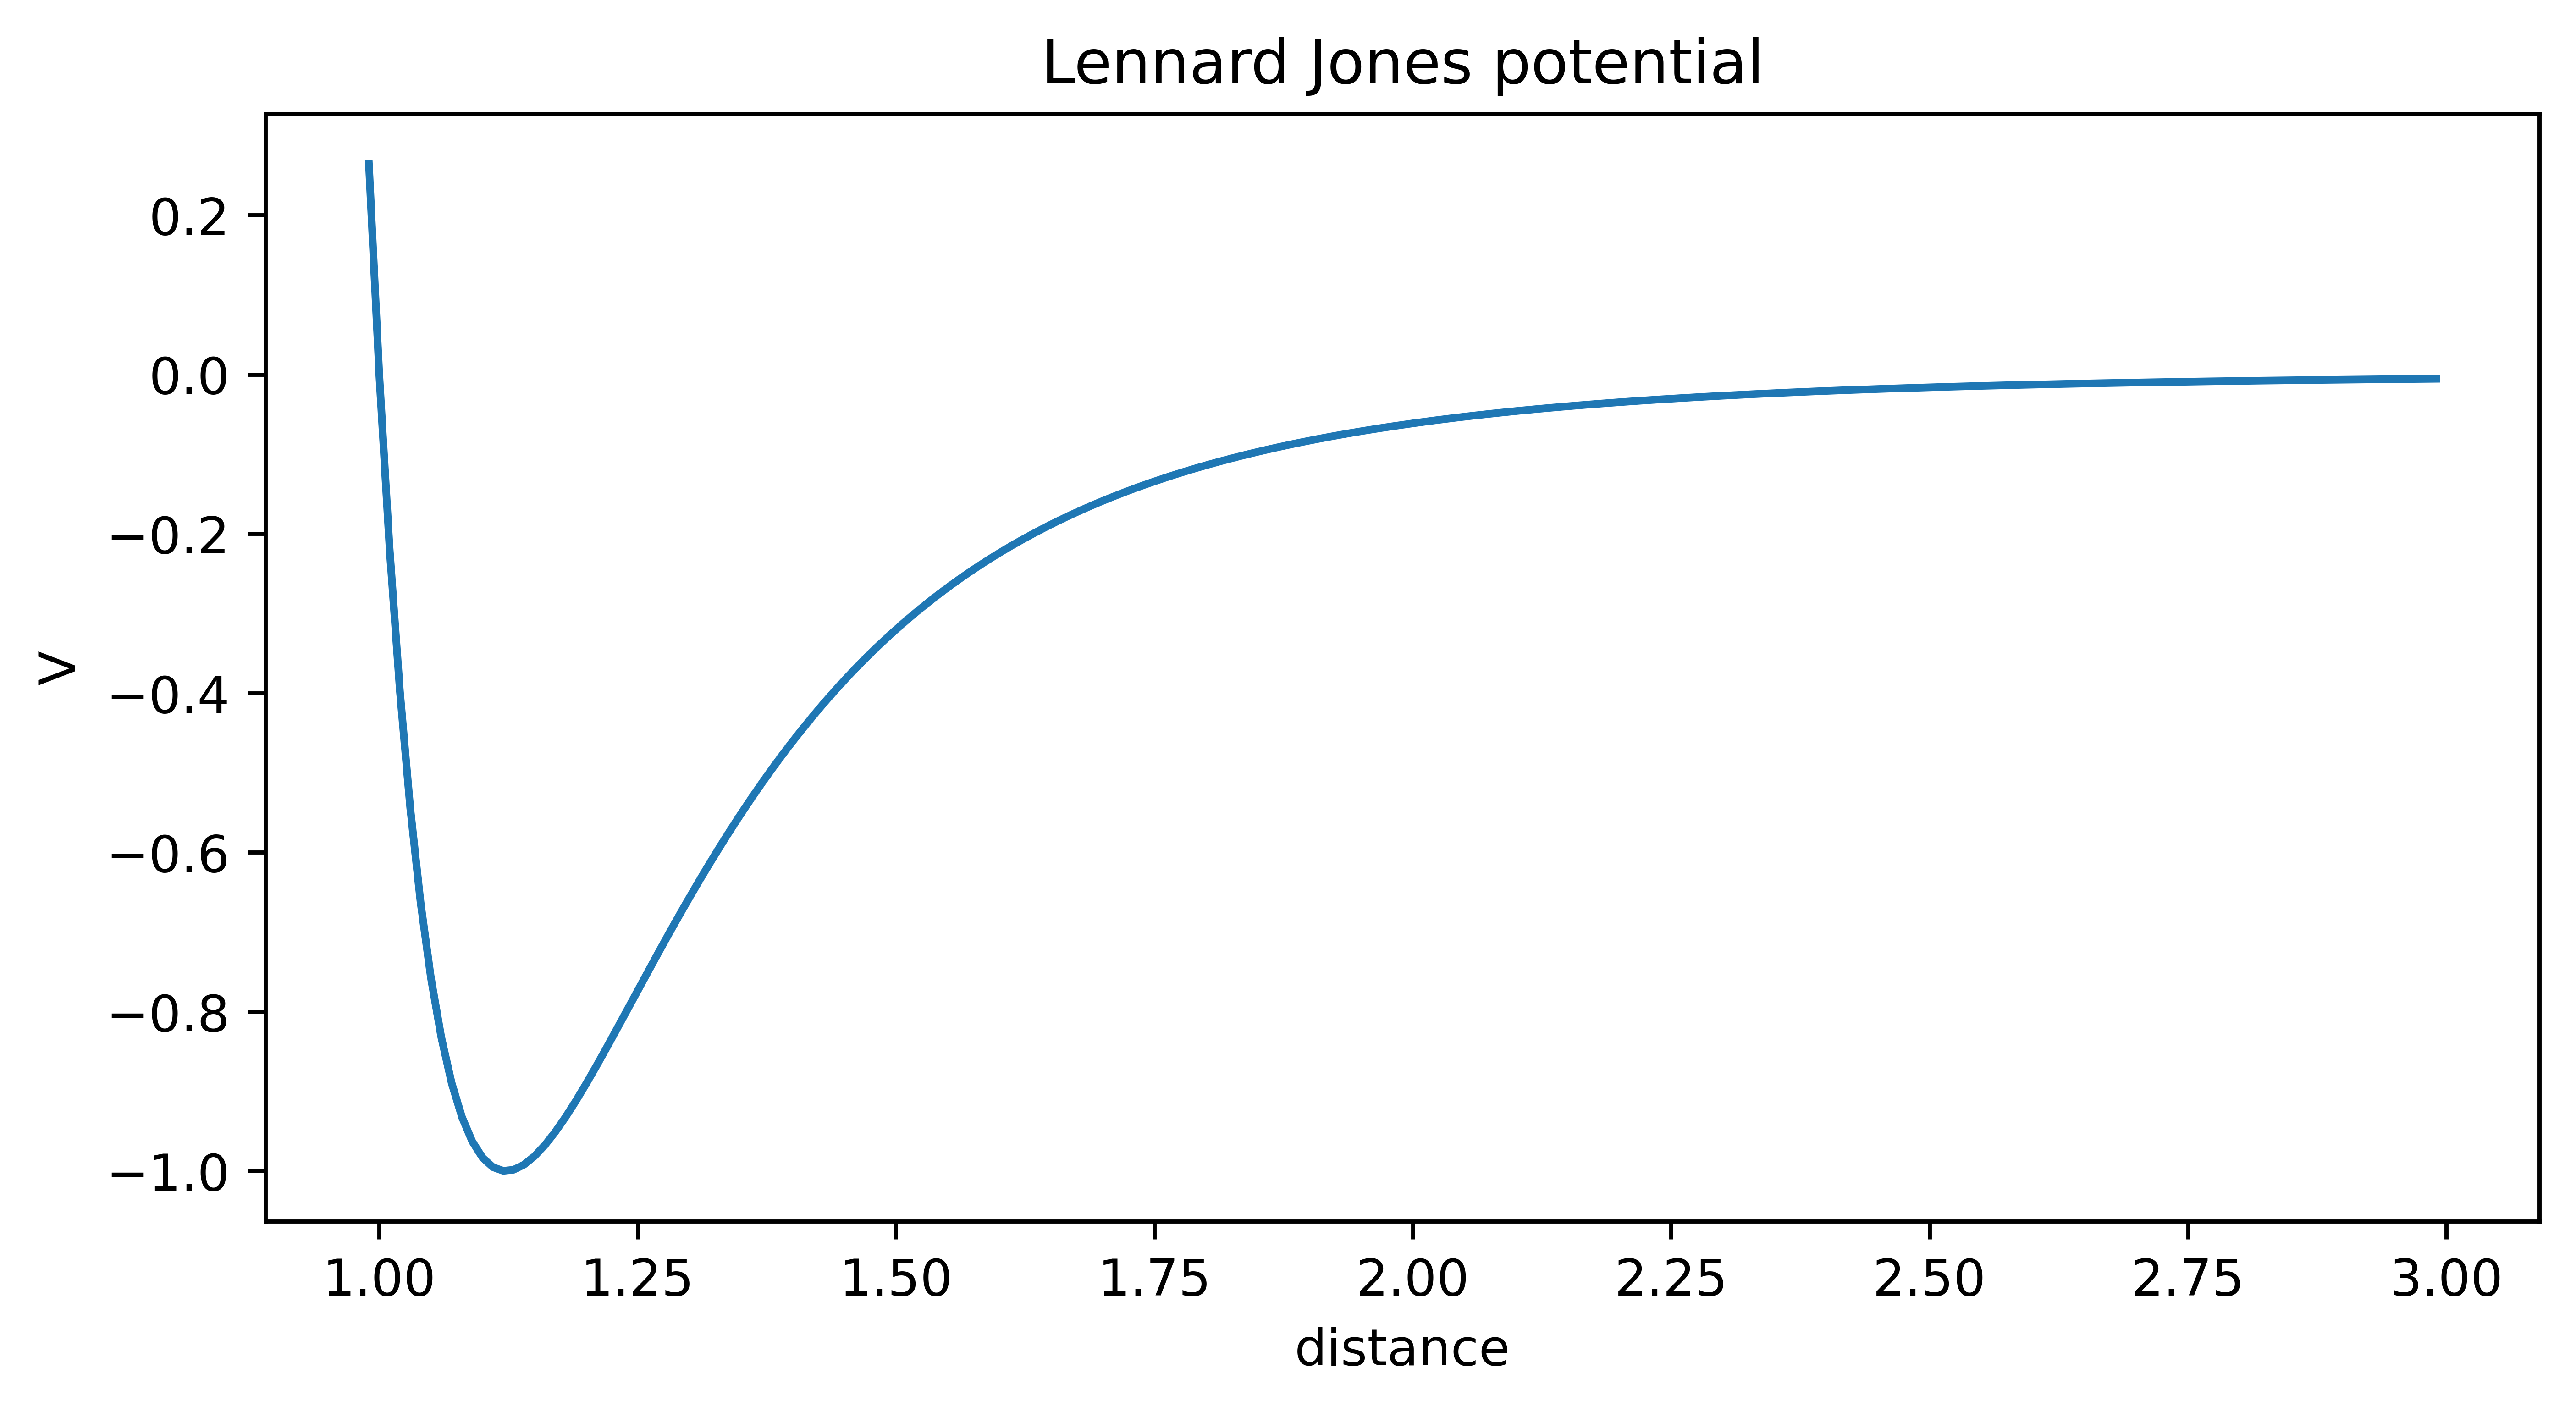

In [2]:
x = np.arange(0.99,3,0.01)
y =  4* ( (1./pow(x,12)) - (1./pow(x,6)))
figure(figsize=(8, 4), dpi=400)
plt.plot(x,y)
plt.title("Lennard Jones potential")
plt.xlabel("distance")
plt.ylabel("V")
plt.show()

### Statistical mechanics: the virial theorem

What said up until now was only the foregroud to the calculation of the thermodynamic quantities of interest; the Verlet algorithm and PBC are the computational tool used to perform simulation of the trajectories in phase space. Having simulated the system time evolution the virial theorem comes into play: temperature and pressure can be calculated as the mean value of particular functions of the coordinates in phase space. 

- $$
\langle p_k\frac{\partial \mathcal{H}}{\partial p_k} \rangle = k_B T \to \langle \sum_{i = 1}^{N}|p_i|^2/m_i\rangle = 2\langle K \rangle = k_B T
$$
- $$
\frac{1}{3}\langle \sum_{i = 1}^{N} \vec{r}_i\cdot\vec{f}_i^{tot} \rangle = -N k_B T
$$ 

$\vec{f}^{tot}_i = \vec{f}^{ext}_i + \vec{f}^{int}_i$ indicates sum of external and internal forces. The external forces are related to the external pressure so $\frac{1}{3}\langle \sum_{i = 1}^{N} \vec{r}_i\cdot\vec{f}_i^{ext} \rangle = -PV$ and the *virial* $W$ is defined as: $\frac{1}{3} \sum_{i = 1}^{N} \vec{r}_i\cdot\vec{f}_i^{int} = W$. In this way:

- $$
0 = \frac{1}{3}\langle \sum_{i = 1}^{N} \vec{r}_i\cdot\vec{f}_i^{tot} \rangle + N k_B T = \frac{1}{3}\langle \sum_{i = 1}^{N} \vec{r}_i\cdot\vec{f}_i^{int} \rangle + \frac{1}{3}\langle \sum_{i = 1}^{N} \vec{r}_i\cdot\vec{f}_i^{ext} \rangle + N k_B T = \langle W \rangle - PV + N k_B T
$$

which in turn yields:
$$
P = \rho k_B T + \langle W \rangle /V
$$

### Exercise 04.1/04.2

The first part of the exercise consists in implementing in the given simulation code the possibility to compute th pressure making use of the virial theorem. In the second part of the exercise a system of Argon in a simulation box containing 108 particles in three different states is performed in the following conditions:

1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

The values of natural units are $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu

#### Equilibration

An important step in the exercise is the equilibraiton of temperature. Since the Verlet algorithm is not self starting two ingredients are needed:

- a starting positional configuration
- a starting velocity configuration

The positional configuration is chosen as a lattice arrangement; the velocity configuration is chosen picking from the distribution of velocity of a thermodynamic system at temperature T (Gaussian distribution). The initial configuration though is not usually an equilibrium one: the system must be able to reach an equilibrium configuration. This clearly results in a variaiton of the total kinetic energy and so in a varation of the temperature (the virial theorem is used). For the solid and liquid phase the initial temperature decreases, while for the gas phase an increase of the temperature is observed. This is related to the fact that in solid and liquid phase the particles in the starting positions are already close to the minimum configuration, thus any veocity associated to the various particles tends to increase potential energy thus decreasing kinetic energy thus decreasing temperature. In the gaseous phase the density is much lower and the particles are far from the potential minimum thus the tendency is reversed with respect with the other two cases. This problem is avoided starting from a different (suitable) temperature from the target one

Finally the reported results are obtained via data blocking using 30 blocks and 5000 Verlet time steps

In [3]:
t1, T1, e_T1 = np.loadtxt("Solid_sim/Eq_temp.dat", usecols=(0,1,2), unpack='true')
x1, f1, err1 = np.loadtxt("Solid_sim/output_epot.dat", usecols = (0,2,3), unpack = True)
x2, f2, err2 = np.loadtxt("Solid_sim/output_temp.dat", usecols = (0,2,3), unpack = True)
x3, f3, err3 = np.loadtxt("Solid_sim/output_ekin.dat", usecols = (0,2,3), unpack = True)
x4, f4, err4 = np.loadtxt("Solid_sim/output_etot.dat", usecols = (0,2,3), unpack = True)
x5, f5, err5 = np.loadtxt("Solid_sim/output_press.dat", usecols = (0,2,3), unpack = True)


In [4]:
fig, axs = plt.subplots(3,2, figsize = (15,15), dpi = 300)
fig.suptitle("SOLID PHASE", fontsize = 20)
fig.tight_layout(pad = 5.0)
axs[0,0].plot(t1, T1, label = "simulation T")
axs[0,0].plot(t1, e_T1, label = "target T")
axs[0][1].errorbar(x1, f1, yerr = err1)
axs[1][0].errorbar(x2, f2, yerr = err2)
axs[1][1].errorbar(x3, f3, yerr = err3)
axs[2][0].errorbar(x4, f4, yerr = err4)
axs[2][1].errorbar(x5, f5, yerr = err5)
axs[0][0].set_title("Equilibration of temperature")
axs[0][0].set_ylabel("Temperature")
axs[0][1].set_title("Potential energy")
axs[0][1].set_ylabel("$U$")
axs[1][0].set_title("Temperature")
axs[1][0].set_ylabel("$T$")
axs[1][1].set_title("Kinetic energy")
axs[1][1].set_ylabel("$K$")
axs[2][0].set_title("Total energy")
axs[2][0].set_ylabel("$E$")
axs[2][1].set_title("Pressure")
axs[2][1].set_ylabel("$P$")
axs[0][0].set_xlabel("Steps")
axs[0][1].set_xlabel("Block number")
for i in range(2):
    for j in range(2):
        axs[i+1][j].set_xlabel("Block number")
for i in range(3):
    for j in range(2):
        axs[i][j].grid()
axs[0][0].legend()
plt.show()

In [5]:
t1, T1, e_T1 = np.loadtxt("Liquid_sim/Eq_temp.dat", usecols=(0,1,2), unpack='true')
x1, f1, err1 = np.loadtxt("Liquid_sim/output_epot.dat", usecols = (0,2,3), unpack = True)
x2, f2, err2 = np.loadtxt("Liquid_sim/output_temp.dat", usecols = (0,2,3), unpack = True)
x3, f3, err3 = np.loadtxt("Liquid_sim/output_ekin.dat", usecols = (0,2,3), unpack = True)
x4, f4, err4 = np.loadtxt("Liquid_sim/output_etot.dat", usecols = (0,2,3), unpack = True)
x5, f5, err5 = np.loadtxt("Liquid_sim/output_press.dat", usecols = (0,2,3), unpack = True)

In [6]:
fig, axs = plt.subplots(3,2, figsize = (15,15), dpi = 300)
fig.suptitle("LIQUID PHASE", fontsize = 20)
fig.tight_layout(pad = 5.0)
axs[0,0].plot(t1, T1, label = "simulation T")
axs[0,0].plot(t1, e_T1, label = "target T")
axs[0][1].errorbar(x1, f1, yerr = err1)
axs[1][0].errorbar(x2, f2, yerr = err2)
axs[1][1].errorbar(x3, f3, yerr = err3)
axs[2][0].errorbar(x4, f4, yerr = err4)
axs[2][1].errorbar(x5, f5, yerr = err5)
axs[0][0].set_title("Equilibration of temperature")
axs[0][0].set_ylabel("Temperature")
axs[0][1].set_title("Potential energy")
axs[0][1].set_ylabel("$U$")
axs[1][0].set_title("Temperature")
axs[1][0].set_ylabel("$T$")
axs[1][1].set_title("Kinetic energy")
axs[1][1].set_ylabel("$K$")
axs[2][0].set_title("Total energy")
axs[2][0].set_ylabel("$E$")
axs[2][1].set_title("Pressure")
axs[2][1].set_ylabel("$P$")
axs[0][0].set_xlabel("Steps")
axs[0][1].set_xlabel("Block number")
for i in range(2):
    for j in range(2):
        axs[i+1][j].set_xlabel("Block number")
for i in range(3):
    for j in range(2):
        axs[i][j].grid()
axs[0][0].legend()
plt.show()

In [7]:
t1, T1, e_T1 = np.loadtxt("Gas_sim/Eq_temp.dat", usecols=(0,1,2), unpack='true')
x1, f1, err1 = np.loadtxt("Gas_sim/output_epot.dat", usecols = (0,2,3), unpack = True)
x2, f2, err2 = np.loadtxt("Gas_sim/output_temp.dat", usecols = (0,2,3), unpack = True)
x3, f3, err3 = np.loadtxt("Gas_sim/output_ekin.dat", usecols = (0,2,3), unpack = True)
x4, f4, err4 = np.loadtxt("Gas_sim/output_etot.dat", usecols = (0,2,3), unpack = True)
x5, f5, err5 = np.loadtxt("Gas_sim/output_press.dat", usecols = (0,2,3), unpack = True)

In [8]:
fig, axs = plt.subplots(3,2, figsize = (15,15), dpi = 300)
fig.suptitle("GAS PHASE", fontsize = 20)
fig.tight_layout(pad = 5.0)
axs[0,0].plot(t1, T1, label = "simulation T")
axs[0,0].plot(t1, e_T1, label = "target T")
axs[0][1].errorbar(x1, f1, yerr = err1)
axs[1][0].errorbar(x2, f2, yerr = err2)
axs[1][1].errorbar(x3, f3, yerr = err3)
axs[2][0].errorbar(x4, f4, yerr = err4)
axs[2][1].errorbar(x5, f5, yerr = err5)
axs[0][0].set_title("Equilibration of temperature")
axs[0][0].set_ylabel("Temperature")
axs[0][1].set_title("Potential energy")
axs[0][1].set_ylabel("$U$")
axs[1][0].set_title("Temperature")
axs[1][0].set_ylabel("$T$")
axs[1][1].set_title("Kinetic energy")
axs[1][1].set_ylabel("$K$")
axs[2][0].set_title("Total energy")
axs[2][0].set_ylabel("$E$")
axs[2][1].set_title("Pressure")
axs[2][1].set_ylabel("$P$")
axs[0][0].set_xlabel("Steps")
axs[0][1].set_xlabel("Block number")
for i in range(2):
    for j in range(2):
        axs[i+1][j].set_xlabel("Block number")
for i in range(3):
    for j in range(2):
        axs[i][j].grid()
axs[0][0].legend()
plt.show()